### LSTM

Long Short Term Memory networks(**LSTM**) : It is special kind of recurrent neural network that is capable of learning long term dependencies in data. This is achieved because the recurring module of the model has a combination of four layers interacting with each other.
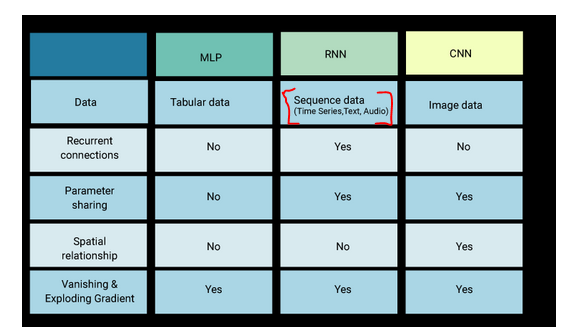

#### In our case we will be using  the LSTM model to predict the average price per KG

# <a id='0'>Contents</a>


* [1. Importing Modules](#module_import)
* [2. Loading and cleaning data](#datacleaning)
* [3. Deep Learning with LSTM](#DeepLearning)

<a id="module_import"></a>
# <a id="1">1. Importing Modules</a>  

Importing all the modules and dependancies

In [116]:
import pandas as pd
import numpy as np

#modules for deep learning with LSTM
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

#additional modules
from sklearn.preprocessing import MinMaxScaler
from matplotlib import rcParams
import pyodbc
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

<a id="datacleaning"></a>
# <a id="1">2. Loading and cleaning data</a>  

**Creating a database connection**

In [5]:
#Creating a connection
conn = pyodbc.connect(driver='{SQL Server}',
                      host='DESKTOP-0SIPQ7F\SQLEXPRESS',
                      database='Fresh_Produce_Market_Data', #Database name
                      trusted_connection='tcon',
                      user='sa')
# Return a new Cursor object using the connection.
cur = conn.cursor()

**Loading data**

In [46]:
df = pd.read_sql_query('select * from dbo.Durban_Fresh_produce_market',conn)
df['Date']=pd.to_datetime(df['Date'])
df.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date
0,ABC JUICE,0.33,,OA003,TRANSVAAL,0.00,0.00,0.00,0,0,0,1500,2020-08-20
1,ABC JUICE,0.75,,OB008,TRANSVAAL,0.00,0.00,0.00,0,0,0,530,2020-08-20
2,AMADUMBE,13.50,,A1135,NATAL,160.00,160.00,160.00,5600,35,472.5,19,2020-08-20
3,AMADUMBE,25.00,,SC250,NATAL,440.00,440.00,440.00,1760,4,100,0,2020-08-20
4,APPLE,0.33,,OA003,TRANSVAAL,0.00,0.00,0.00,0,0,0,2180,2020-08-20


**Calculating the Avarage price per KG as our target variable**

In [47]:
df['ave_per_kg']=df['Average_Price'].astype(float)/df['Weight_Kg'].astype(float)
df.head()

,Commodities,Weight_Kg,Size_Grade,Container,Province,Low_Price,High_Price,Average_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,Date,ave_per_kg
0,ABC JUICE,0.33,,OA003,TRANSVAAL,0.00,0.00,0.00,0,0,0,1500,2020-08-20,0.000000
1,ABC JUICE,0.75,,OB008,TRANSVAAL,0.00,0.00,0.00,0,0,0,530,2020-08-20,0.000000
2,AMADUMBE,13.50,,A1135,NATAL,160.00,160.00,160.00,5600,35,472.5,19,2020-08-20,11.851852
3,AMADUMBE,25.00,,SC250,NATAL,440.00,440.00,440.00,1760,4,100,0,2020-08-20,17.600000
4,APPLE,0.33,,OA003,TRANSVAAL,0.00,0.00,0.00,0,0,0,2180,2020-08-20,0.000000


Changing all digital data to numeric

In [48]:
df['Weight_Kg']=pd.to_numeric(df['Weight_Kg'])
df['Low_Price']=pd.to_numeric(df['Low_Price']) 
df['High_Price']=pd.to_numeric(df['High_Price']) 
df['Average_Price']=pd.to_numeric(df['Average_Price']) 
df['Sales_Total']=pd.to_numeric(df['Sales_Total'])
df['Total_Qty_Sold']=pd.to_numeric(df['Total_Qty_Sold']) 
df['Total_Kg_Sold']=pd.to_numeric(df['Total_Kg_Sold'])
df['Stock_On_Hand']=pd.to_numeric(df['Stock_On_Hand'])

Below is a function that filteres and cleanes the data depending on what information we want to filter

In [50]:
def filter_data(df,commodity,weight,size):
    
    """
    Function that takes a dataframe, consolidates repeated sales  and returns filtred information based on commodity type, weight and size.

    Parameter(s):
    -------------
    df       : DataFrame
    commodity: Commodity name
    weight   : weight of commodity
    size     : size of commodity
    
    Return
    ------
    DataFrame: Dataframe with filtered information
    
    """
    
    #filtering the data that we wantr
    filtered_df=df[(df['Commodities']==commodity) & (df['Weight_Kg'] == weight)& (df['Size_Grade'] == size)]
    
    #consolidating repeated sales
    filtered_df = filtered_df.groupby(['Province', 'Container', 'Size_Grade', 'Weight_Kg', 'Commodities', 'Date'])[['Low_Price', 'High_Price', 'Sales_Total', 'Total_Qty_Sold', 'Total_Kg_Sold', 'Stock_On_Hand','ave_per_kg']].agg(
        {
            'Low_Price':min,
            'High_Price':max,
            'Sales_Total':sum,
            'Total_Qty_Sold':sum,
            'Total_Kg_Sold':sum,
            'Stock_On_Hand':sum,
            'ave_per_kg':max
        }
    )
    
    filtered_df.reset_index(inplace=True)
    

    
    return filtered_df

In [51]:
filtered_df=filter_data(df,'APPLE GOLDEN DELICIOUS',18.30,'1L')
filtered_df.head()

,Province,Container,Size_Grade,Weight_Kg,Commodities,Date,Low_Price,High_Price,Sales_Total,Total_Qty_Sold,Total_Kg_Sold,Stock_On_Hand,ave_per_kg
0,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2019-12-11,0.0,220.0,220.0,1.0,18.3,211.0,12.021858
1,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2019-12-12,0.0,240.0,1320.0,6.0,109.8,783.0,13.114754
2,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2019-12-14,180.0,200.0,15300.0,81.0,1482.3,575.0,10.928962
3,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2019-12-23,0.0,200.0,10870.0,69.0,1262.7,1048.0,10.382514
4,CAPE,M4183,1L,18.3,APPLE GOLDEN DELICIOUS,2019-12-30,100.0,200.0,19140.0,120.0,2196.0,661.0,9.113661


<a id="DeepLearning"></a>
# <a id="3">3. Deep Learning with LSTM</a>  

In this section we will be using the LSTM model to predict the future average price per KG

In [72]:
price_kg=filtered_df.groupby(['Date']).mean()[['ave_per_kg']]
price_kg.head()

,ave_per_kg
Date,
2019-12-11,12.750455
2019-12-12,13.114754
2019-12-14,7.650273
2019-12-23,12.204007
2019-12-30,8.138069


**Using the Backfill method to fill in the data for missing business days**

In [73]:
price_kg=price_kg.asfreq('B', method='backfill')
price_kg.head()

,ave_per_kg
Date,
2019-12-11,12.750455
2019-12-12,13.114754
2019-12-13,7.650273
2019-12-16,12.204007
2019-12-17,12.204007


**Graph overview of our data**

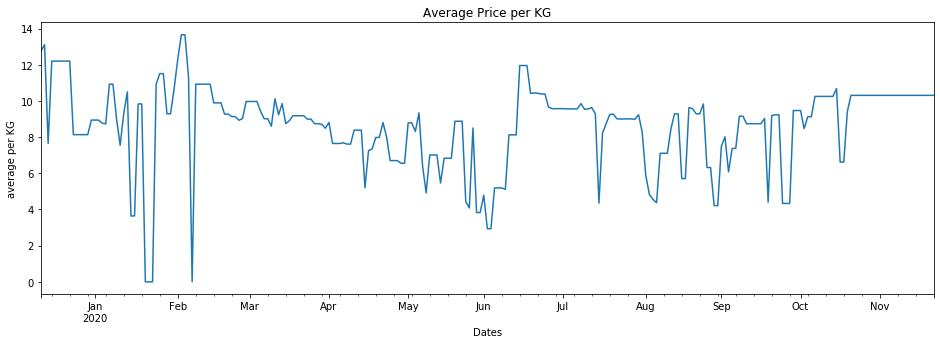

In [75]:
ax = price_kg['ave_per_kg'].plot(figsize = (16,5), title = "Average Price per KG")
ax.set(xlabel='Dates', ylabel='average per KG')
plt.show()

For test data we want to predict average price per kg for the last 2 months(which is 40 business days)

In [76]:
#Splitting the daata to train and test sets
train_data = price_kg.iloc[:-60]
test_data = price_kg.iloc[-60:]

Creating scaler to scale data between the range or (0,1)

In [77]:
#Creating scaler to scale data between the range or (0,1)
scaler = MinMaxScaler()
scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [78]:
test_data_scaled[:5]

array([[0.54776   ],
       [0.58696   ],
       [0.44525333],
       [0.54      ],
       [0.54      ]])

**Creating a time series generator from keras for our scaled train and test data**

In [106]:
generator = TimeseriesGenerator(train_data_scaled, train_data_scaled, length=15, batch_size=1)

**LSTM model**

In [107]:
model = Sequential()
model.add(LSTM(150, activation='relu', input_shape=(15, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, 150)               91200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 151       
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [108]:
#fitting the model
model.fit_generator(generator,epochs=30)

Epoch 1/30
174/174 [==============================] - 3s 15ms/step - loss: 0.0546
Epoch 2/30
174/174 [==============================] - 3s 15ms/step - loss: 0.0297
Epoch 3/30
174/174 [==============================] - 3s 15ms/step - loss: 0.0326
Epoch 4/30
174/174 [==============================] - 3s 17ms/step - loss: 0.0287: 0s - los
Epoch 5/30
174/174 [==============================] - 3s 18ms/step - loss: 0.0273
Epoch 6/30
174/174 [==============================] - 3s 18ms/step - loss: 0.0273
Epoch 7/30
174/174 [==============================] - 3s 18ms/step - loss: 0.0255
Epoch 8/30
174/174 [==============================] - 3s 18ms/step - loss: 0.0260
Epoch 9/30
174/174 [==============================] - 3s 18ms/step - loss: 0.0240: 0s - loss: 0.0
Epoch 10/30
174/174 [==============================] - 3s 18ms/step - loss: 0.0228
Epoch 11/30
174/174 [==============================] - 3s 17ms/step - loss: 0.0260: 0s - loss:
Epoch 12/30
174/174 [==============================] - 3s 

Using the model to predict the average price per KG

In [113]:
output=[]
reshaped_data=np.reshape(train_data_scaled[-15:],(1, 15, 1))
for i in range(len(test_data_scaled)):
    prediction=model.predict(reshaped_data)[0]
    output.append(prediction)
    reshaped_data=np.append(reshaped_data[:,1:,:],[[prediction]],axis=1) 

In [114]:
output = scaler.inverse_transform(output)
test_data['prediction'] = output
test_data.head()

,ave_per_kg,prediction
Date,,
2020-09-01,7.483060,5.861552
2020-09-02,8.018579,6.615737
2020-09-03,6.082696,7.014547
2020-09-04,7.377049,7.312444
2020-09-07,7.377049,7.547756


Plotting the results

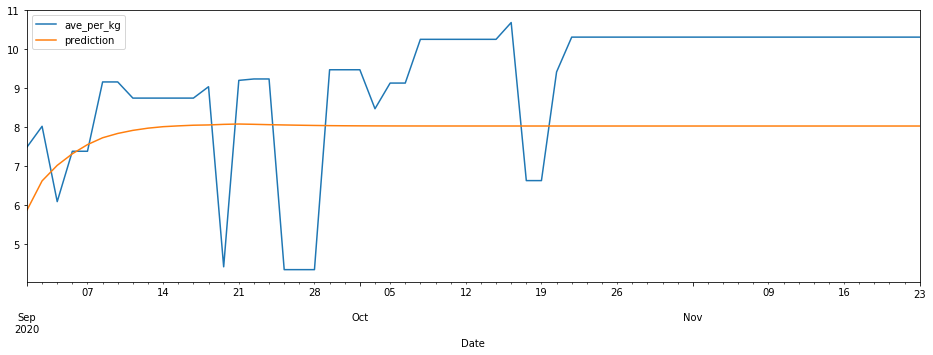

In [115]:
test_data['ave_per_kg'].plot(figsize = (16,5), legend=True)
test_data['prediction'].plot(legend = True)